# SNGP demonstration

This is a faithful representation of the TensorFlow SNGP notebook [1], but translated into pytorch.

We also do a few extra things, like plot MC dropout as well.

[1] https://www.tensorflow.org/tutorials/understanding/sngp

This notebook takes the half moons dataset, and applies an affine transformation to a larger dimension, to simulate a higher dimensional input. That means it performs a matrix multiplication and addtion $$ y_i = W_{ij} x_j + b_i $$. This ensures that the higher dimensional input still has a learnable class structure. The matrix $W$ and bias $b$ are randomly initialized and fixed.

### Imports

Import the SNGP layers

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

from sngp_classification_layer import SNGP
from gaussian_process import mean_field_logits

### Setup

Plotting utilities used throughout the notebook

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

from tqdm import tqdm
import pandas as pd

plt.rcParams['figure.dpi'] = 90

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100


def make_training_data(sample_size=500):
    """Create two moon training dataset."""
    train_examples, train_labels = sklearn.datasets.make_moons(
        n_samples=2 * sample_size, noise=0.1
    )

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return train_examples, train_labels

def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

def plot_uncertainty_surface(test_uncertainty, ax, cmap=None, show_data=True):
    """Visualizes the 2D uncertainty surface.

    For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).

    Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

    Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
    """
    # Normalize uncertainty for better visualization.
    test_uncertainty = test_uncertainty / np.max(test_uncertainty)

    # Set view limits.
    ax.set_ylim(DEFAULT_Y_RANGE)
    ax.set_xlim(DEFAULT_X_RANGE)

    # Plot normalized uncertainty surface.
    pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

    # Plot training data.
    if show_data:
        ax.scatter(train_examples[:, 0], train_examples[:, 1],
                 c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
        ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

    return pcm
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X, self.y = X.astype(np.float32), y.astype(int)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class BaselineModel(nn.Module):
    def __init__(self, D=2, C=2, H=128, p=0.1, n_hidden=4):
        super().__init__()
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=p)
        self.register_buffer('input_W', torch.randn(D, H))
        self.register_buffer('input_b', torch.randn(H))
        self.fcs = nn.ModuleList([nn.Linear(H, H) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(H, C)
        
    def forward(self, x, masks=None):
        x = x @ self.input_W + self.input_b
        for i in range(len(self.fcs)):
            if masks is not None:
                x = x + self.act(self.fcs[i](x)) * masks[i]
            x = x + self.dropout(self.act(self.fcs[i](x)))
        return self.output_layer(x)

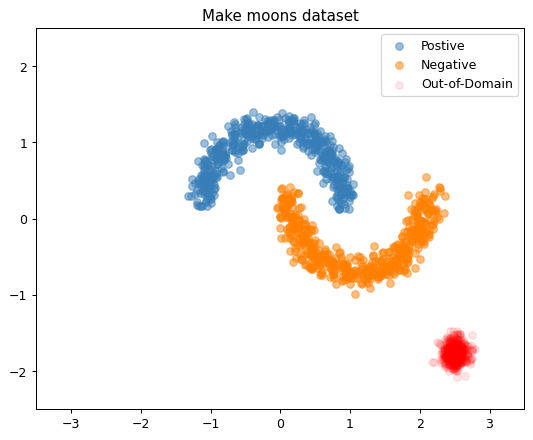

In [5]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500
)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)
plt.title('Make moons dataset')

plt.show()

## Baseline Model

We train a baseline resnet model to use to compare with our SNGP model. It is able to fit the data perfectly, however it is unaware of input distances relative to the train set, and so it incorrectly predicts confidently on out-of-domain data.

### Train

In [7]:
model = BaselineModel()

optim = torch.optim.Adam(model.parameters())
loader = torch.utils.data.DataLoader(Dataset(train_examples, train_labels), batch_size=64)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(1, 100+1):
    c, running_loss = 1, 0
    for x, y in loader:
        optim.zero_grad()
        yhat = model(x)
        y = y.long()
        loss = loss_fn(yhat, y)
        loss.backward()
        optim.step()
        running_loss += float(loss)
        c += 1
    if not epoch % 10:
        print(f"Epoch {epoch}. Loss: {running_loss / c}")
model.eval()

Epoch 10. Loss: 0.002445082801654387
Epoch 20. Loss: 0.00041803181203945046
Epoch 30. Loss: 0.00017056239502220277
Epoch 40. Loss: 0.00012934833156417452
Epoch 50. Loss: 4.2237836891324736e-05
Epoch 60. Loss: 6.066303669339344e-05
Epoch 70. Loss: 2.3568682656653383e-05
Epoch 80. Loss: 1.735359116055941e-05
Epoch 90. Loss: 1.1140585801218977e-05
Epoch 100. Loss: 3.5286368783464934e-05


BaselineModel(
  (act): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fcs): ModuleList(
    (0-3): 4 x Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
)

### Evaluate on test set

In [8]:
eval_loader = torch.utils.data.DataLoader(Dataset(test_examples, test_examples), batch_size=256)
logits = []
for x, _ in eval_loader:
    with torch.no_grad():
        logits.append(model(x).detach().numpy())
logits = np.concatenate(logits, axis=0)
with torch.no_grad():
    probs = torch.softmax(torch.tensor(logits, dtype=torch.float32), dim=-1)[:, 0].detach().numpy()

### Plot the baseline

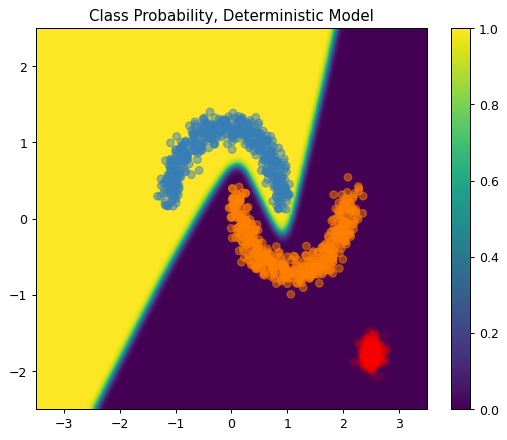

In [9]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(probs, ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

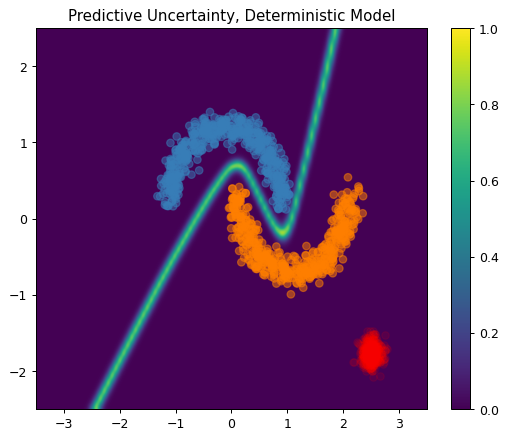

In [10]:
resnet_uncertainty = probs * (1 - probs)

_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()

## Monte Carlo Dropout

We can keep the same model we just trained. Now, we generate some random dropout masks and make forward passes for each mask. This is like sampling from a distribution of possible models induced by the Bernoulli distribution on Dropout

In [11]:
def make_masks(n_layers, hidden_dim):
    return [torch.bernoulli(torch.empty(128).uniform_()) for _ in range(n_layers)]

n_layers = len(model.fcs)
hidden_dim = 128

logit_samples = []

for i in tqdm(range(24)):
    masks = make_masks(n_layers, hidden_dim)
    eval_loader = torch.utils.data.DataLoader(Dataset(test_examples, test_examples), batch_size=256)
    logits = []
    for x, _ in eval_loader:
        with torch.no_grad():
            logits.append(model(x, masks=masks).detach().numpy())
    logits = np.concatenate(logits, axis=0)
    logit_samples.append(logits[None, :]) # add the sample dimension (size 12) at zero to concatenate along.
    
logit_samples = np.concatenate(logit_samples)
mean = np.mean(logit_samples, axis=0)
variance = np.var(logit_samples, axis=0) ** 2
logits = mean / np.sqrt(1 + variance)
    
with torch.no_grad():
    probs = torch.softmax(torch.tensor(logits, dtype=torch.float32), dim=-1)[:, 0].detach().numpy()

100%|██████████| 24/24 [00:03<00:00,  7.79it/s]


In [12]:
with torch.no_grad():
    probs = torch.softmax(torch.tensor(logits, dtype=torch.float32), dim=-1)[:, 0].detach().numpy()
    
with torch.no_grad():
    mean_probs = torch.softmax(torch.tensor(mean, dtype=torch.float32), dim=-1)[:, 0].detach().numpy()

### Mean results

These are the results of averaging 24 mc dropout forward passes. As you can see, the model is quite confident and still retains a 100% train accuracy.

However, it is overly certain about the out-of-domain red blob

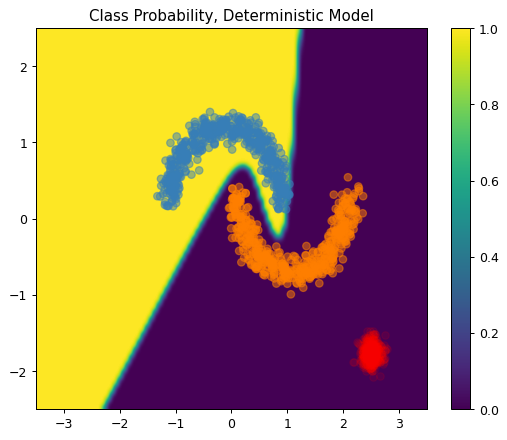

In [13]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(mean_probs, ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

### MC Dropout logits

We now factor in the uncertainty via the computed variance using the mean field approximation.

Note, that since $p=0.5$ corresponds to a logit value of $0$, dividing logits by an positive number **will not affect its prediction**. However, a large value will move the prediction closer to the decision boundary of 0.5, i.e. making our prediction uncertain.

Notice how below, the model still has an uncertainty boundary that is correlated with the mean decision boundary. there are still large dark areas where it is overly certain.

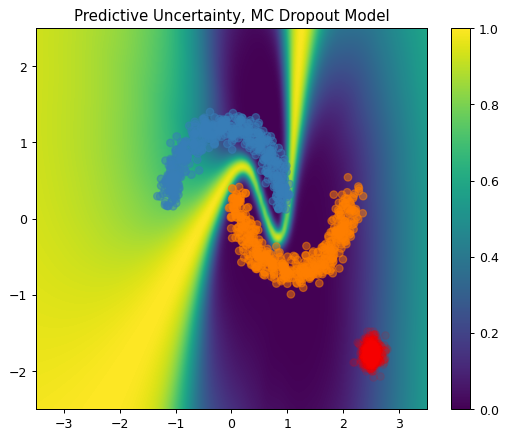

In [14]:
resnet_uncertainty = probs * (1 - probs)

_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, MC Dropout Model")

plt.show()

## SNGP model

Now we build the SNGP model.

Things to note:

1. Training is longer. It takes more epochs to hit good quality. 
2. The precision metric is better during training (when the model guesses, it guesses correctly)
3. If the random feature dimension is greater than the hidden dimension, it will not train

In [15]:
class SNGPModel(nn.Module):
    def __init__(self, in_features, num_classes, up_projection_dim):
        super().__init__()
        self.register_buffer('input_W', torch.randn(in_features, up_projection_dim))
        self.register_buffer('input_b', torch.randn(up_projection_dim))
        self.classifier = SNGP(
            in_features=up_projection_dim,
            num_classes=num_classes,
            kernel_scale_trainable=True,
            scale_random_features=True,
            normalize_input=False,
            covariance_momentum=0.999,
            return_dict=False,
        )
            
    def forward(self, x):
        x =  x @ self.input_W + self.input_b
        return self.classifier(x)

In [17]:
input_dim = 2
num_classes = 2
up_projection_dim = 128

model = SNGPModel(
    in_features=input_dim, 
    num_classes=num_classes,
    up_projection_dim=up_projection_dim,
)

optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
loader = torch.utils.data.DataLoader(Dataset(train_examples, train_labels), batch_size=64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss(reduction='mean')

model.train()
model = model.to(device)
for epoch in range(1, 150+1):
    running_loss, c = 0, 0
    for x, y in loader:
        optim.zero_grad()
        logits, covariance = model(x.to(device))
        y = y.long()
        loss = loss_fn(logits, y.to(device))
        loss.backward()
        optim.step()
        running_loss += float(loss)
        c += 1
    if not epoch % 10:
        print(f"Epoch {epoch}. Loss: {running_loss / c}")
#     model.classifier.reset_precision()
model.eval()

Epoch 10. Loss: 0.0893763939384371
Epoch 20. Loss: 0.028654755966272205
Epoch 30. Loss: 0.01629611014504917
Epoch 40. Loss: 0.008249203354353085
Epoch 50. Loss: 0.0077687668963335454
Epoch 60. Loss: 0.004277493280824274
Epoch 70. Loss: 0.0034254364218213595
Epoch 80. Loss: 0.0026609894339344464
Epoch 90. Loss: 0.002206652679888066
Epoch 100. Loss: 0.0016971751392702572
Epoch 110. Loss: 0.001156142825493589
Epoch 120. Loss: 0.002911419425799977
Epoch 130. Loss: 0.0008647720023873262
Epoch 140. Loss: 0.000866186212078901
Epoch 150. Loss: 0.0007058162918838207


SNGPModel(
  (classifier): SNGP(
    (pre_classifier): Linear(in_features=128, out_features=128, bias=True)
    (reduce_dim_layer): Linear(in_features=128, out_features=128, bias=True)
    (gp_classifier): RandomFeatureGaussianProcess(
      (random_feature_layer): RandomFourierFeatures()
      (covariance_layer): LaplaceRandomFeatureCovariance()
      (output_layer): Linear(in_features=1024, out_features=2, bias=False)
    )
    (activation): Tanh()
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

## Plot

Observe the magic that is a Gaussian Process.

The thing to note is that the certainty is clustered only around points near the input data. Since we computed a normal distribution for the output logits, the proper way to get the final output probability would be to monte carlo sample

$$ p(\mathbb{E}[x]) = \frac{1}{M} \sum_{i=1}^M \text{logits}_i $$

with $\text{logits}_i \sim \mathcal{N}(\mu, \Sigma)$ is drawn from a normal distribution, and $\Sigma$ has size (N, N) for N the test dimension. This is computationally more demanding, as it involves making batch predictions, and scales quadratically with batch size N. Furthermore, we must make M samples from a multi-variate normal distribution, which also takes time.

We instead employ the mean-field approximation, which assumes erases the "co" part of "covariance". Simply put, the covariance tells us the effect that knowledge of points 1, 2, ..., i-1, i+1, ..., N have on point i. Mean field says that, on average, we can think of each point feeling the effect of some "mean" point. In physics (the *correct* way to interpret this ;)), you could view this as imagine this as feeling some effective charge given a big pool of charged particles doing random stuff. 

Or, maybe you can think of it has standing in a big crowd, and even though everyone in the crowd is standing at different locations and moving around, on average, you always hear the same noise any direction you turn 

In [18]:
eval_loader = torch.utils.data.DataLoader(Dataset(test_examples, test_examples), batch_size=256)
logits = []
covs = []
for x, _ in eval_loader:
    with torch.no_grad():
        l, c = model(x.to(device))
        l = mean_field_logits(l, c)
        logits.append(l.detach().cpu().numpy())
        covs.append(np.diag(c.detach().cpu().numpy())[:, None])
        
logits = np.concatenate(logits, axis=0)
covs = np.concatenate(covs, axis=0)

with torch.no_grad():
    probs2 = torch.softmax(torch.tensor(logits), dim=1)[:, 0].detach().numpy()

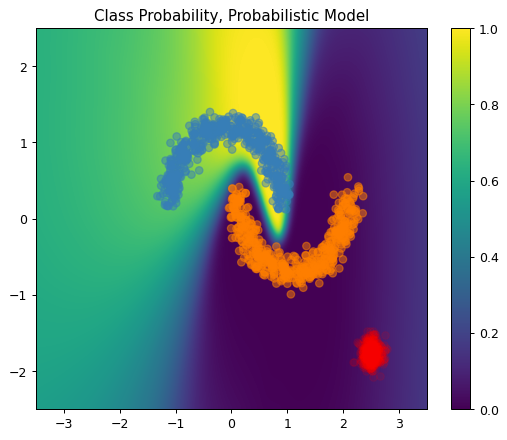

In [19]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(probs, ax=ax, show_data=True)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Probabilistic Model")

plt.show()

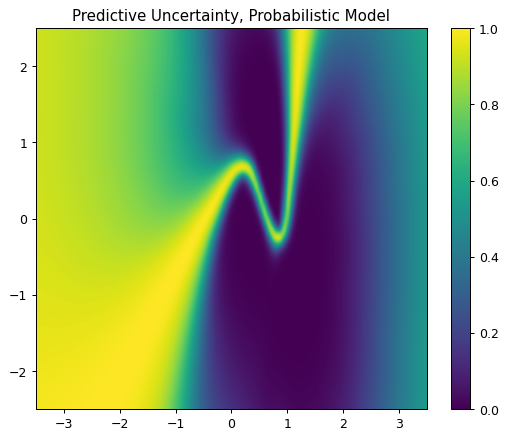

In [22]:
uncertainty = probs * (1 - probs)

_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(uncertainty, ax=ax, show_data=False)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Probabilistic Model")

plt.show()